<h1> Variational Autoencoder </h1>
Traditional Autoencoders form dense representations with not a lot of meaningful "structure". This is fine when all you want to do is compress an input and then reconstruct it, but what if you then want to generate new images by sampling the representation space (latent space)? Small movements is the latent space lead to large and discontinuous jumps in the reconstructed output. We need to apply an additional loss to force the created latent space to be smooth and nicely structured.
<img src="https://miro.medium.com/max/1687/1*22cSCfmktNIwH5m__u2ffA.png" width="1200" align="center">

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

In [5]:
batchSize = 64
lr = 1e-4

# Number of Training epochs
nepoch = 10

# The size of the Latent Vector
latent_size = 128
root = "."

In [6]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])])

train_set = Datasets.MNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batchSize,shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=root, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:07<00:00, 1366809.37it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 431779.34it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 958188.65it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1765899.96it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



## KL Divergence penalty (loss)

The KL divergance between two normal distributions where:

\begin{equation*}
p(x) = N(\mu_p,\sigma_p)
\end{equation*}

\begin{equation*}
q(x) = N(\mu_q,\sigma_q)
\end{equation*}
                                                          
\begin{equation*}
KL(p,q) = \ln(\frac{\sigma_q}{\sigma_p}) + \frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{2\sigma_q^2} - \frac{1}{2}
\end{equation*}

With a VAE using the Encoder we produce a $\sigma$ and a $\mu$ per dimension and sample from normal distribution (once per dimension) with the given $\sigma$ and $\mu$. We then pass this sampled vector to the Decoder which will try and reconstruct the original image.<br>
The KL penalty (or loss) tries to force the distribution from the encoder to be that of a unit gaussian where $\sigma=1$ and $\mu =0$ (also known as a Standard Normal Distribution).<br>
To do this we create a loss using the KL Divergence (a value that is always positive) between the distribution produced by the encoder and that of a unit gaussian.<br>


So the above becomes:
\begin{equation*}
p(x) = N(\mu_p,\sigma_p)
\end{equation*}

\begin{equation*}
q(x) = N(0,1)
\end{equation*}

\begin{equation*}
KL(p,q) = \ln(\frac{1}{\sigma_p}) + \frac{\sigma_p^2 + (\mu_p - 0)^2}{2*1^2} - \frac{1}{2}
\end{equation*}

Which we can simplify to:
\begin{equation*}
KL(p,q) = -\frac{1}{2}(2\ln(\sigma_p) - \sigma_p^2 - \mu_p^2 + 1)
\end{equation*}

If we minimise this we bring our distribution closer to a unit Gaussian <br><br>
Note: $\sigma$ must always be $\ge0$, instead of forcing this on our network we usually use $\ln(\sigma^2)$ or the "log variance" in its place (literally the log of the variance $\sigma^2$ which simplifies to $2\ln(\sigma)$ which we can see in our equation above). This value is continuous in the range of $-\infty$ to $\infty$

## Why do we even bother??
There is more then meets the eye with what is actually going in a VAE and what happens when we implement a KL penalty, for a good explanation we won't be able to beat check-out these great write-ups: <br>
[Blog: Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)<br>
[Blog: Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

What is the ELBO and how does it apply to a VAE? <br>
[Youtube: Evidence Lower Bound (ELBO) - CLEARLY EXPLAINED!](https://www.youtube.com/watch?v=IXsA5Rpp25w&ab_channel=KapilSachdeva)

In [7]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x)
    
    # Here is our KL divergance loss implemented in code
    # We will use the mean across the dimensions instead of the sum (which is common and would require different scaling)
    kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    
    # We'll tune the "strength" of KL divergance loss to get a good result 
    loss = recon_loss + 0.1 * kl_loss
    return loss

## VAE Network
The structure is very similar to a vanilla Auto Encoder with the addition of a $\sigma$ output on the encoder.<br>
It is functionally different as we sample from a standard normal distribution and scale it with $\sigma$ and shift with $\mu$.<br> This functionally the same as sampling from $N(\mu,\sigma)$<br>
Note: we only do this during training, during test time we just use $\mu$

In [8]:
# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_out)
        
        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x_skip = self.conv3(x)
        
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.conv2(x) + x_skip
        
        return F.elu(self.bn2(x))
    
    
# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        
        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = F.elu(self.bn2(x_in))
        
        x_skip = self.up_nn(self.conv3(x))
        
        x = self.up_nn(F.elu(self.bn2(self.conv1(x))))
        return self.conv2(x) + x_skip

    
# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch)
        self.conv_block2 = DownBlock(ch, ch * 2)
        self.conv_block3 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and 
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map 
        # (in practice it's the same thing)
        self.conv_mu = nn.Conv2d(4 * ch, z, 4, 1)
        self.conv_logvar = nn.Conv2d(4 * ch, z, 4, 1)

    # This function will sample from our distribution
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = F.elu(self.conv_1(x))
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        x = self.sample(mu, logvar)
        
        return x, mu, logvar
    
    
class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, z = 32):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)
        
        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_block3 = UpBlock(ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = F.elu(self.conv_block3(x))

        return torch.tanh(self.conv_out(x))

In [9]:
class VAE(nn.Module):
    def __init__(self, channel_in, ch=16, z=32):
        super(VAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, z=z)
        self.decoder = Decoder(channels=channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding, mu, logvar = self.encoder(x)
        
        # Only sample during training or when we want to generate new images
        # just use mu otherwise
        if self.training:
            x = self.decoder(encoding)
        else:
            x = self.decoder(mu)
            
        return x, mu, logvar

In [11]:
# Get a test image
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

# View the shape
test_images.shape

torch.Size([64, 1, 32, 32])

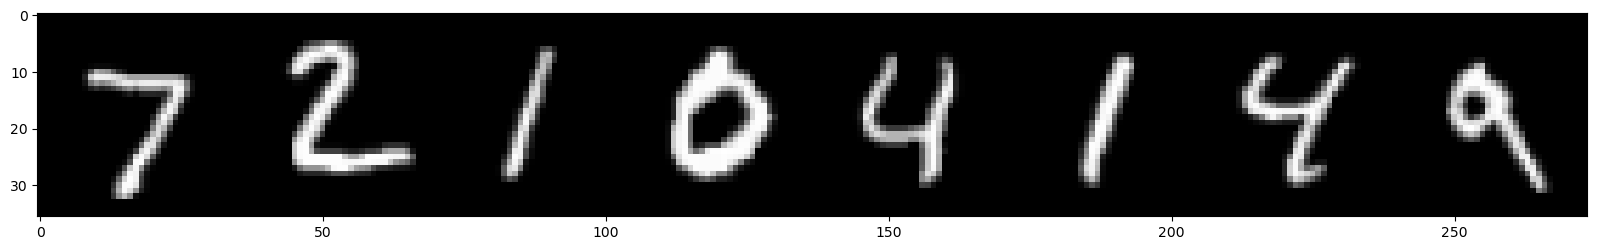

In [12]:
# Visualize the data!!!
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [14]:
device = 'cpu'

In [15]:
# Create our network
vae_net = VAE(channel_in=1, z=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))

# Create loss logger
loss_log = []
train_loss = 0

In [16]:
# Pass through a test image to make sure everything is working
recon_data, mu, logvar = vae_net(test_images.to(device))

# View the Latent vector shape
mu.shape

torch.Size([64, 128, 1, 1])

In [17]:
pbar = trange(0, nepoch, leave=False, desc="Epoch")   
vae_net.train()
train_loss = 0
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)

        # Forward pass the image in the data tuple
        recon_data, mu, logvar = vae_net(image)
        
        # Calculate the loss
        loss = vae_loss(recon_data, image, mu, logvar)
        
        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()

        # Take a training step
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021DC77BEB60>
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
  File "C:\Users\admin\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py", line 1443, in _shutdown_workers
  File "C:\Users\admin\anaconda3\Lib\multiprocessing\process.py", line 149, in join
  File "C:\Users\admin\anaconda3\Lib\multiprocessing\popen_spawn_win32.py", line 110, in wait
KeyboardInterrupt: 


KeyboardInterrupt: 

## Results!

In [ ]:
_ = plt.plot(loss_log[1000:])
_ = plt.title("VAE Loss")

In [ ]:
vae_net.eval()
recon_data, mu, logvar = vae_net(test_images.to(device))

Ground Truth

In [ ]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Reconstruction

In [ ]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Random Permutations

In [ ]:
rand_samp = vae_net.decoder(mu + 1 * torch.randn_like(mu))
plt.figure(figsize = (20,10))
out = vutils.make_grid(rand_samp.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
rand_samp = vae_net.decoder(torch.randn_like(mu))
plt.figure(figsize = (20,10))
out = vutils.make_grid(rand_samp.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Interpolation in Latent Space
Now that we've trained our VAE we can explore the "MNIST Latent Space" it has created. <br>
We first use our validation images and class labels to find the mean latent vector for each class

In [ ]:
# Initialise the class means to 0
class_means = torch.zeros(10, latent_size)

vae_net.eval()
# Loop through all the data in the validation set
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        recon_data, mu, _ = vae_net(images.to(device))
        
        # For each batch sum up the latent vectors of the same class
        # (Use a matrix of one hot coded vectors to make it easy)
        class_matrix = F.one_hot(labels, 10).t().type(torch.FloatTensor)
        class_means += torch.matmul(class_matrix, mu.squeeze().detach().cpu())

# In the validation set each class has 1000 images so to find the mean vectors we divide by 1000
class_means /= 1000

Recondstruct the means using the decoder

In [ ]:
# Reshape the mean classes to the appropriate shape 
class_means = class_means.view(10, latent_size, 1, 1)

# We only need to pass the latent vectors through our decoder
recon_means = vae_net.decoder(class_means.to(device))

Plot out our class means!

In [ ]:
plt.figure(figsize = (20, 10))
out = vutils.make_grid(recon_means.detach().cpu(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Interpolate between two class means

In [ ]:
# Pick the two classes to move between
start_class = 4
end_class = 7

# Number of interpolation steps
num_steps = 100
steps = torch.linspace(0,1,num_steps)

# Get the vector pointing from one class to the other
diff_vector = class_means[end_class] - class_means[start_class]

Take "num_steps" from the "start_class" to the "end_class" along the "diff_vector"

In [ ]:
latent_steps = class_means[start_class] + (steps.view(num_steps, 1, 1, 1) * diff_vector.view(1, latent_size, 1, 1))
recon_steps = vae_net.decoder(latent_steps.to(device))

Visualize the interpolation

In [ ]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_steps.detach().cpu(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

Animate!

In [ ]:
for i in range(num_steps):
    plt.imshow(((recon_steps[i, 0] + 1) / 2).detach().cpu())
    plt.pause(0.01)
    clear_output(True)